In [163]:
import sqlite3
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import lsst.afw.image as afwImage
from lsst.daf.persistence import Butler
from astropy.table import vstack, Table
from astropy.visualization import ZScaleInterval
interval = ZScaleInterval()
import fakeInjectionPipeline as fip
import data_process_utils as dpu
import analysis_utils as au
import os
import glob
import lsst.afw.image as afwImage
from lsst.afw.table import BaseCatalog
import imp
imp.reload(au) 

<module 'analysis_utils' from '/global/cscratch1/sd/shl159/projects/fake_injection_summer_2022/dia_improvement/devel/analysis_utils.py'>

In [2]:
"""
config_list = ['al_spatial1', 'al_spatial2', 'al_spatial3', 'al_spatial4',
               'al_spatial1Pca', 'al_spatial2Pca', 'al_spatial3Pca', 'al_spatial4Pca']
patch_list = ['00', '11', '22', '33', '44', '55', '66']
host_mag_list = ['20_21']
fake_mag_list = [20]
injection_db_path = './data/table/gal_4639/injection_coord.sqlite'
calexp_info_dict, injection_coord_dict = fip.get_calexp_injection_dict(
    patch_list, host_mag_list, dbpath=injection_db_path
)
"""

In [8]:
"""
fake_dir = f'./data/patch_0to6/injection'
injector = fip.fakeInjectionPipeline(
    fake_dir = fake_dir, patch_list = patch_list,
    host_mag_list=host_mag_list, fake_mag_list=fake_mag_list,
    calexp_info_dict=calexp_info_dict, injection_coord_dict=injection_coord_dict
)
for cf_type in config_list:
    config = f'./config/diffimConfig_{cf_type}.py'
    file_path = f'./spatial_{cf_type}.sh'
    diff_dir =  f'./data/patch_0to6/spatial_dof/{cf_type}'
    injector.get_subtraction_script(diff_dir , config=config,
                                    file_path=file_path, use_slurm=True)
""";

In [27]:
"""
for cf_type in config_list:
    diff_dir =  f'./data/patch_0to6/spatial_dof/{cf_type}'
    fip.check_exsistance(patch_list, host_mag_list, fake_mag_list, calexp_info_dict, diff_dir)
""";

In [17]:
"""
for cf_type in config_list:
    diff_dir =  f'./data/patch_0to6/spatial_dof/{cf_type}'
    flux_dir = f'./data/patch_0to6/spatial_dof/{cf_type}/detection'
    injector.get_detection(diff_dir=diff_dir, flux_dir=flux_dir,
                           db_name=f'detection.sqlite')
""";

# Analysis

#### get psf info

In [96]:
psf_table = Table.read('./data/table/gal_4639/psf_fwhm.csv', format='ascii.csv')

In [97]:
psf_table['psf_ratio'] = (psf_table['calexp_fwhm'] - psf_table['coadd_fwhm']) / psf_table['coadd_fwhm']    

In [98]:
# len(psf_table[psf_table['psf_ratio']>=0])
# len(psf_table[np.logical_and(psf_table['psf_ratio']<0, psf_table['psf_ratio']>=-0.05)])
# len(psf_table[psf_table['psf_ratio']<-0.05])

In [99]:
psf_broad = psf_table[psf_table['psf_ratio']>=0]
print(len(psf_broad))

30


#### get data

In [257]:
config_list = ['al_spatial1', 'al_spatial2', 'al_spatial3', 'al_spatial4',
               'al_spatial1Pca', 'al_spatial2Pca', 'al_spatial3Pca', 'al_spatial4Pca']
base_flags = ['base_PixelFlags_flag_saturated', 'base_PixelFlags_flag_saturatedCenter', 'base_PixelFlags_flag_suspect',
              'base_PixelFlags_flag_suspectCenter', 'base_PixelFlags_flag_offimage', 'base_PixelFlags_flag_edge',
              'base_PixelFlags_flag_bad', 'base_NaiveCentroid_flag']
dipole_flags = ['ip_diffim_DipoleFit_flag_classification', 'ip_diffim_DipoleFit_flag_classificationAttempted']

In [119]:
flux_dict = {}
for config in config_list:
    conn = sqlite3.connect(f'./data/patch_0to6/spatial_dof/{config}/detection/detection.sqlite')
    flux = pd.DataFrame()
    for row in psf_broad:
        patch, visit, det = row['patch'], int(row['visit']), int(row['detector'])
        patch = patch[0] + patch[2]
        query = (f"SELECT * FROM fake_src WHERE patch='{patch}' "
                 f"AND visit={visit} AND detector={det}")
        fake = pd.read_sql_query(query, conn)
        flux = pd.concat([flux, fake])
    flux_dict[config] = flux

In [262]:
remaining_art_dict = {}
artifact_stat = pd.DataFrame(index=['all artifacts', 'base flag applied', 'dipole flag applied'])

for config in config_list:
    conn = sqlite3.connect(f'./data/patch_0to6/spatial_dof/{config}/detection/detection.sqlite')
    art = pd.DataFrame()
    for row in psf_broad:
        patch, visit, det = row['patch'], int(row['visit']), int(row['detector'])
        patch = patch[0] + patch[2]
        query = (f"SELECT * FROM artifact WHERE patch='{patch}' "
                 f"AND visit={visit} AND detector={det}")
        artifact = pd.read_sql_query(query, conn)
        art = pd.concat([art, artifact])
    art = Table.from_pandas(art)
    base_rm = dpu.remove_flag_astropy(art, flag_list=base_flags)
    base_rm['snr'] = base_rm['base_PsfFlux_instFlux'] / base_rm['base_PsfFlux_instFluxErr']
    dipole_rm = dpu.remove_flag_astropy(base_rm, flag_list=dipole_flags)
    artifact_stat[config.split('_')[1]] = [len(art), len(base_rm), len(dipole_rm)]
    remaining_art_dict[config] = base_rm

In [271]:
# efficiency and flags
eff_stat = pd.DataFrame(index=['no flag applied', 'base flag applied', 'dipole flag applied'])
for j, config in enumerate(config_list):
    flux = flux_dict[config]
    flux_det = flux.loc[flux.matched_status.astype(bool)]
    eff = np.round(len(flux_det) / len(flux), 3)
    flux_det_astropy = Table.from_pandas(flux_det)
    base_rm = dpu.remove_flag_astropy(flux_det_astropy, flag_list=base_flags)
    dipole_rm = dpu.remove_flag_astropy(base_rm, flag_list=dipole_flags)
    eff_stat[config.split('_')[1]] = [eff, np.round(len(base_rm)/ len(flux), 3),
                                           np.round(len(dipole_rm)/ len(flux), 3)]

In [268]:
# flux residual and flux pull
res_list = []
df_list = []
for j, config in enumerate(config_list):
    flux = flux_dict[config]
    flux_det = flux.loc[flux.matched_status.astype(bool)]
    res = (flux_det.base_PsfFlux_instFlux - flux_det.injected_instFlux) / flux_det.injected_instFlux
    res_list.append(list(res))
    df = (flux_det.base_PsfFlux_instFlux - flux_det.injected_instFlux) / flux_det.base_PsfFlux_instFluxErr
    df_list.append(df)

#### Algorithm (Alard-Lupton)

\begin{align}
M(x,y) &= [R \otimes K](x, y) + B(x,y),  \\
K(u,v,x,y) &= \Sigma_{q=1}^{N_k}a_q(x,y)k_q(u,v), \\
a_q(x,y) &= \Sigma_{m=0}^{d_q} \Sigma_{n=0}^{d_q-m}a_{qmn}(\frac{x-x_c}{N_x})^m(\frac{y-y_c}{N_y})^n, \\
B(x,y) &= \Sigma_{k=0}^{d_B} \Sigma_{l=0}^{d_B-k}b_{kl}(\frac{x-x_c}{N_x})^k(\frac{y-y_c}{N_y})^l.
\end{align}

In this notebook, we explore the effect of $d_q$ on artifact removal.

#### artifact statistics

In [259]:
artifact_stat
# 30 image pairs (calexp psf fwhm > coadd psf fwhm)

,spatial1,spatial2,spatial3,spatial4,spatial1Pca,spatial2Pca,spatial3Pca,spatial4Pca
all artifacts,681,661,621,587,747,735,740,736
base flag applied,261,230,195,158,319,306,314,309
dipole flag applied,165,148,136,102,192,183,193,181


In [272]:
eff_stat
# fake mag: 20

,spatial1,spatial2,spatial3,spatial4,spatial1Pca,spatial2Pca,spatial3Pca,spatial4Pca
no flag applied,1.000,1.0,1.0,1.0,1.000,1.000,1.000,1.0
base flag applied,1.000,1.0,1.0,1.0,1.000,1.000,1.000,1.0
dipole flag applied,0.998,1.0,1.0,1.0,0.998,0.998,0.998,1.0


#### flux residual

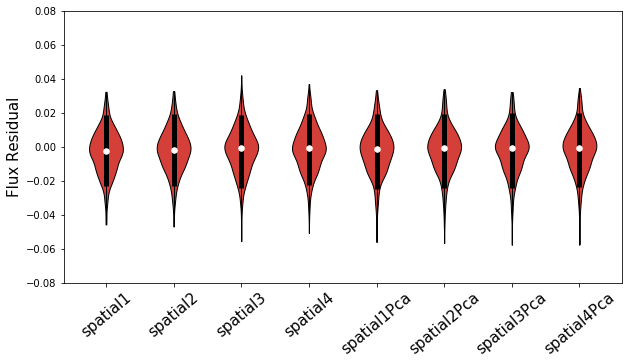

In [260]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
fig.subplots_adjust(hspace=0.5, wspace=0.2)
res_sorted = []
for r in res_list:
    res_arr = np.array(r)
    res_arr.sort() 
    res_sorted.append(res_arr)

parts = ax.violinplot(res_sorted, showmedians=False, showextrema=False)

for pc in parts['bodies']:
    pc.set_facecolor('#D43F3A')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
    
quartile1, medians, quartile3 = np.percentile(res_sorted, [5, 50, 95], axis=1)
whiskers_min, whiskers_max = np.array(res_sorted)[:,0], np.array(res_sorted)[:,-1]
    
inds = np.arange(1, len(medians) + 1)
ax.scatter(inds, medians, marker='o', color='white', s=30, zorder=3)
ax.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)

ax.vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)

ax.set_xticks(inds)
ax.set_xticklabels(['spatial1', 'spatial2', 'spatial3', 'spatial4',
                    'spatial1Pca', 'spatial2Pca', 'spatial3Pca', 'spatial4Pca'],  rotation=40, size=15)
ax.tick_params(axis='y', labelsize=10)
ax.set_ylabel('Flux Residual', size=15)
ax.set_ylim((-0.08, 0.08));


#### flux pull

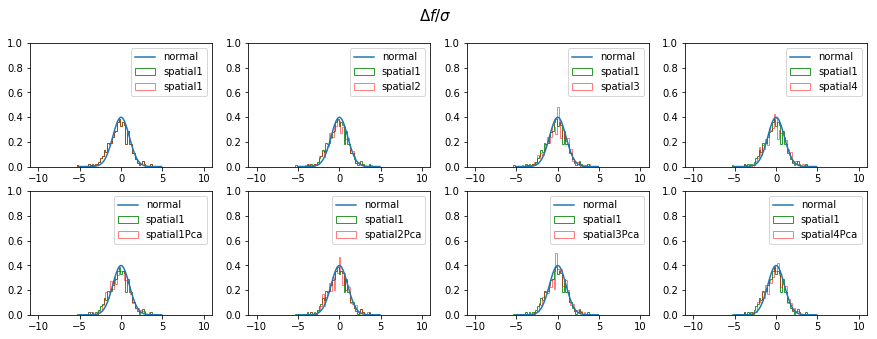

In [139]:
norm_x = np.arange(-5, 5, 0.1)
norm_y = stats.norm.pdf(norm_x)fig, ax = plt.subplots(2, 4, figsize=(15, 5))
ax_ls = ax.flat
bins = np.linspace(-10, 10, 100)
for i, config in enumerate(config_list):
    df = df_list[i]
    ax_ls[i].plot(norm_x, norm_y, label='normal')
    ax_ls[i].hist(df_list[0] ,density=True,
                  bins=bins,color='green', histtype='step', alpha=0.8, label=config_list[0].split('_')[1])
    ax_ls[i].hist(df ,density=True, bins=bins,color='red', alpha=0.5, histtype='step', label=config.split('_')[1])
    ax_ls[i].set_ylim((0,1))
    ax_ls[i].legend()
plt.suptitle('$\Delta f / \sigma$', size=15);

#### artifact snr distribution

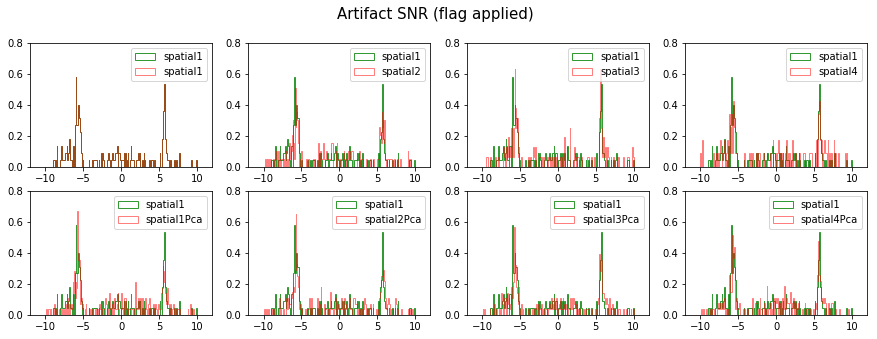

In [273]:
fig, ax = plt.subplots(2, 4, figsize=(15, 5))
ax_ls = ax.flat
bins = np.linspace(-10, 10, 200)
for i, config in enumerate(config_list):
    
    snr = remaining_art_dict[config]['snr'].data.data
    ax_ls[i].hist(remaining_art_dict['al_spatial1']['snr'].data.data,
                  density=True, bins=bins,color='green', histtype='step', alpha=0.8, label='spatial1')
    ax_ls[i].hist(snr ,density=True, bins=bins,color='red', histtype='step', alpha=0.5, label=config.split('_')[1])
    # ax_ls[i].set_title(f'Flux Pull', size=15)
    # ax_ls[i].set_xlabel('SNR', size=15)
    ax_ls[i].set_xlim((-12,12))
    ax_ls[i].set_ylim((0,0.8))
    ax_ls[i].legend()
plt.suptitle('Artifact SNR (flag applied)', size=15);


#### postage stamps

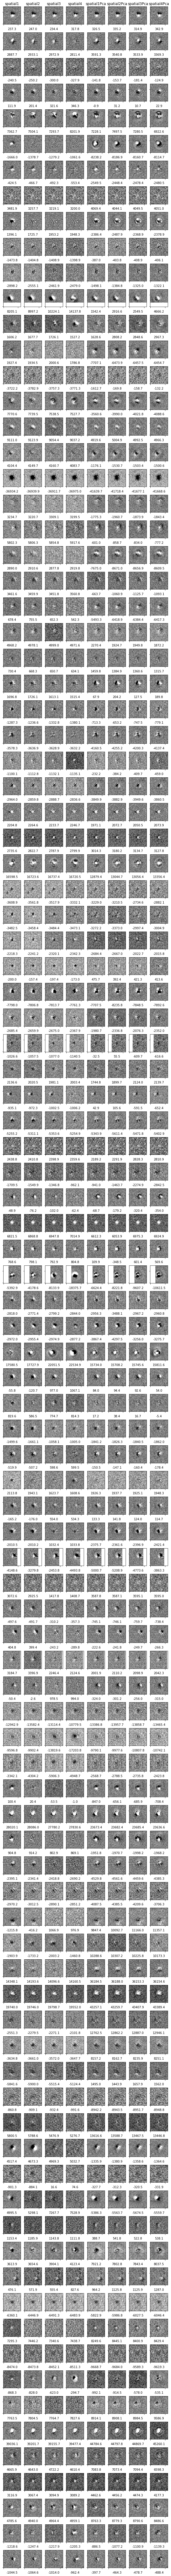

In [192]:
row_len = 100
fig, ax = plt.subplots(row_len, len(config_list), figsize=(10,160))
fig.subplots_adjust(wspace=0.2)
row_id = 0
return_up = 0
atfifact_df = remaining_art_dict['al_spatial1'].to_pandas()
for col_id, config in enumerate(config_list):        
    ax[0][col_id].set_title(config.split('_')[1])
    for dia in psf_broad:
        if return_up == 1:
            return_up -= 1
            break
        patch, visit, det = dia['patch'], int(dia['visit']), int(dia['detector'])
        patch = patch[0] + patch[2]
        art_sliced = au.slice_df(atfifact_df,
                                equal={'visit': visit, 'detector':det, 'patch':patch})
        art_astropy = Table.from_pandas(art_sliced)
        path_template = dia['diffexp_path']
        path_split = path_template.split('/')
        path_split[3] = 'spatial_dof'
        path_split[4] = config
        diffexp_path = '/'.join(path_split)
        diff_exp = afwImage.ExposureF(diffexp_path)
        for diaSrc in art_astropy:
            x = diaSrc['base_NaiveCentroid_x']
            y = diaSrc['base_NaiveCentroid_y']
            diff_stamp = dpu.make_cutout(diff_exp, x, y, cutout_size=30)
            flux_sum = np.nansum(diff_stamp.getImage().array)
            ax[row_id][col_id].imshow(interval(diff_stamp.getImage().array), cmap='gray', origin='lower')
            ax[row_id][col_id].set_xlabel(f'{flux_sum:.1f}')
            ax[row_id][col_id].set_xticklabels([])
            ax[row_id][col_id].set_yticklabels([])
            row_id += 1
            if row_id == row_len:
                row_id = 0
                return_up += 1
                print('\n')
                break